In this notebook we create the FRISIA parameters for any aggregation of coastal segments from the DIVA and CIAM input data. Sections that have to be adapted for creating a new type of aggregation are marked by

#ADAPTME >>>>

...

#ADAPTME <<<<

There are only two such sections within this notebook. The rest of it runs independently.

The default settings here create the "DIVA_regional" parameters, which are already available in the repository

In [1]:
#ADAPTME >>>>
inputFRISIA = '../input/'

# World Bank regions are used here as an example 
AggregationName = 'DIVA_regional'
nreg=7


# Choose scenarios for which to display example data here and create a csv with GDP and pop data in 
# order to later run FRISIA with it
scenarios = ['ssp126', 'ssp245', 'ssp370', 'ssp585']


#ADAPTME <<<<

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import pandas as pd
from netCDF4 import Dataset
import sys
sys.path.append('../')
from src.SLRModel import globalSLRModel

In [3]:
#### Functions taken from CIAM
## var is SLR and areaparams are taken from DIVA
## For no adaptation, this should be straightforward in a global model.
## For perfect protection, this should be 0 as long as protection is good enough.
def calcInundatedArea(areaparams, var):
    
    area = (areaparams[0] * np.maximum(0, np.minimum(0.5, var - 0)) \
            + (areaparams[0] + areaparams[1]) / 2 * np.maximum(0, np.minimum(1, var - 0.5)) \
            + areaparams[1] * np.maximum(0, np.minimum(0.5, var - 1.5)) \
            + areaparams[2] * np.maximum(0, np.minimum(1, var - 2)) \
            + areaparams[3] * np.maximum(0, np.minimum(1, var - 3)) \
            + areaparams[4] * np.maximum(0, np.minimum(1, var - 4)) \
            + areaparams[5] * np.maximum(0, np.minimum(1, var - 5)) \
            + areaparams[6] * np.maximum(0, np.minimum(1, var - 6)) \
            + areaparams[7] * np.maximum(0, np.minimum(1, var - 7)) \
            + areaparams[8] * np.maximum(0, np.minimum(1, var - 8)) \
            + areaparams[9] * np.maximum(0, np.minimum(1, var - 9)) \
            + areaparams[10] * np.maximum(0, np.minimum(1, var - 10)) \
            + areaparams[11] * np.maximum(0, np.minimum(1, var - 11)) \
            + areaparams[12] * np.maximum(0, np.minimum(1, var - 12)) \
            + areaparams[13] * np.maximum(0, np.minimum(1, var - 13)) \
            + areaparams[14] * np.maximum(0, var - 14))

    return area


def calc_pSIGMA(pParams, lslr, H):
    # Calculates the expected value of the storm surge exposure area for 
    # Protect scenarios (i.e. with initial flood protection)
    #
    # pParams[0] = psig0 in CIAM
    # pParams[1] = psig0coef in CIAM
    # pParams[2] = psigA in CIAM
    # pParams[3] = psigB in CIAM
    
    return (pParams[0] + pParams[1] * np.maximum(0, lslr)) / (1.0 + pParams[2] * np.exp(pParams[3] * np.maximum(0, H - lslr)))



#### Getting local SLR

# This function is taken from the BRICK model:
##==============================================================================
## Copyright 2016 Tony Wong, Alexander Bakker
## This file is part of BRICK (Building blocks for Relevant Ice and Climate
## Knowledge). BRICK is free software: you can redistribute it and/or modify
## it under the terms of the GNU General Public License as published by
## the Free Software Foundation, either version 3 of the License, or
## (at your option) any later version.
##
## BRICK is distributed in the hope that it will be useful,
## but WITHOUT ANY WARRANTY; without even the implied warranty of
## MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
## GNU General Public License for more details.
##
## You should have received a copy of the GNU General Public License
## along with BRICK.  If not, see <http://www.gnu.org/licenses/>.
##==============================================================================
# It was translated into python and simplified by Lennart Ramme, MPI-M, Hamburg 2024
def getLocalSLR(lat, lon, SLRs, weights):
    
    # convert input longitude to degrees east and get indices
    if lon<0: lon += 360
    ilat = int(np.floor(lat)+90)
    ilon = int(np.floor(lon))
    
    wt_thermo = 1.0
    wt_LWS = 1.0
    
    wt_MG = float('NaN')
    shift=0
    while np.isnan(np.sum(wt_MG)):
        shift+=1
        wt_MG = np.nanmean(weights[0][ilat-shift:ilat+shift+1, ilon-shift:ilon+shift+1])
        wt_GIS = np.nanmean(weights[1][ilat-shift:ilat+shift+1, ilon-shift:ilon+shift+1])
        wt_AIS = np.nanmean(weights[2][ilat-shift:ilat+shift+1, ilon-shift:ilon+shift+1])
    
    if np.isnan(np.sum(wt_MG)) or np.isnan(np.sum(wt_GIS)) or np.isnan(np.sum(wt_AIS)):
        sys.exit('Only NaNs found around this location: '+str(lat)+' '+str(lon)+' !')
    
    return wt_thermo*SLRs[0] + wt_LWS*SLRs[1] + wt_MG*SLRs[2] + wt_GIS*SLRs[3] + wt_AIS*SLRs[4]

def getlSLRweights(lat,lon,weights):
    # convert input longitude to degrees east and get indices
    if lon<0: lon += 360
    ilat = int(np.floor(lat)+90)
    ilon = int(np.floor(lon))
    
    wt_MG = float('NaN')
    shift=0
    while np.isnan(np.sum(wt_MG)):
        shift+=1
        wt_MG = np.nanmean(weights[0][ilat-shift:ilat+shift+1, ilon-shift:ilon+shift+1])
        wt_GIS = np.nanmean(weights[1][ilat-shift:ilat+shift+1, ilon-shift:ilon+shift+1])
        wt_AIS = np.nanmean(weights[2][ilat-shift:ilat+shift+1, ilon-shift:ilon+shift+1])
    
    if np.isnan(np.sum(wt_MG)) or np.isnan(np.sum(wt_GIS)) or np.isnan(np.sum(wt_AIS)):
        sys.exit('Only NaNs found around this location: '+str(lat)+' '+str(lon)+' !')
        
    return wt_MG, wt_GIS, wt_AIS

In [4]:
n_segs = 12148

scenario_indices = {
    'ssp119' : 0,
    'ssp126' : 1,
    'ssp245' : 2,
    'ssp370' : 3,
    'ssp434' : 4,
    'ssp460' : 5,
    'ssp534' : 6,
    'ssp585' : 7 }

n_sce = len(scenarios)


#### CIAM segment information
CIAM_path = inputFRISIA+'CIAM/'
df = pd.read_csv(CIAM_path+'diva_segment_latlon.csv')

seg_names = df.values[:,0].tolist()
seg_ids = df.values[:,1].tolist()
seg_lons = df.values[:,2]
seg_lats = df.values[:,3]


df = pd.read_csv(CIAM_path+'segments_regions.csv')
segnames_alphabetical = df.values[:,0].tolist()
regnames_alphabetical = df.values[:,1].tolist()


#### GDP per capita and population in segment

seg_ypcc = np.zeros((191,n_segs, len(scenarios)))
seg_pop_region = np.zeros((191,n_segs, len(scenarios)))

# dummy array for getting list of regions in diva segment order
seg_region = [i for i in range(n_segs)]

time_raw = np.linspace(2010,2200,20)
time = np.linspace(2010,2200,191)
for isc, scenario in enumerate(scenarios):
    ssp = scenario[3]
    
    df = pd.read_csv(CIAM_path+'ypcc_IIASAGDP_SSP'+ssp+'_v9_130219.csv')
    df_pop = pd.read_csv(CIAM_path+'pop_IIASAGDP_SSP'+ssp+'_v9_130219.csv')


    ypcc_regions = df.columns.tolist()[1:]
    raw_ypcc = df.values[:,1:]
    raw_pop = df_pop.values[:,1:]


    for i, seg in enumerate(segnames_alphabetical):
        iseg = seg_names.index(seg)
        reg = regnames_alphabetical[segnames_alphabetical.index(seg)]
    
        # index of region in YPCC and pop files
        ireg = ypcc_regions.index(reg)

        seg_ypcc[:,iseg,isc] = np.interp(time, time_raw, raw_ypcc[:,ireg])
        seg_pop_region[:,iseg,isc] = np.interp(time, time_raw, raw_pop[:,ireg])
        seg_region[iseg] = reg

seg_pop_growth_region = seg_pop_region/seg_pop_region[np.newaxis,0,:,:]

In [35]:
############## Creating SLR data ################################
########## FaIR input data for SLR model ########################
n = 3 # number of ensemble members, here we only have 3 for the 17th, 50th and 83rd percentiles from FaIR
nTime = 551
all_T1  = np.zeros((nTime, n_sce, n))
all_ohc = np.zeros((nTime, n_sce, n))

for isc, scenario in enumerate(scenarios):
    df = pd.read_csv(inputFRISIA+'FaIR/T_and_OHC_from_FaIRv2.1.1_calibrationv1.1.0_'+scenario+'.csv')

    all_T1[:,isc,:]  = df.values[:,1:4] - np.mean(df.values[100:150,np.newaxis,1:4], axis=0) # take anomaly to 1850-1900
    all_ohc[:,isc,:] = df.values[:,4:7] - np.mean(df.values[100:150,np.newaxis,4:7], axis=0)

all_ohc_change = np.append(np.zeros_like(all_ohc[0,np.newaxis,:,:]), all_ohc[1:,:,:] - all_ohc[:-1,:,:], axis=0)

T1_median = all_T1[:,:,0]
ohc_change_median = all_ohc_change[:,:,0]
T1_high = all_T1[:,:,2]
ohc_change_high = all_ohc_change[:,:,2]

############### Calculating SLR Model
SLR_total = np.zeros_like(T1_median)
SLR_thermo = np.zeros_like(T1_median)
SLR_MG = np.zeros_like(T1_median)
SLR_LWS = np.zeros_like(T1_median)
SLR_GIS = np.zeros_like(T1_median)
SLR_AIS = np.zeros_like(T1_median)


SLRModel = globalSLRModel(T1_median[:,1], ohc_change_median[:,1], dbg=0)

for sidx in range(n_sce):
    print('Start calculating scenario '+scenarios[sidx])

    SLRModel.T_anomaly = T1_high[:,sidx] # Use upper end values here to increase fit range
    SLRModel.OHC_change = ohc_change_high[:,sidx] # as above
    SLRModel.reset_SLR()
    SLRModel.integrate()
    SLRModel.align(1993, silent=True)
        
    SLR_total[:,sidx] = SLRModel.getSLRTotal()
    SLR_thermo[:,sidx] = SLRModel.getSLRThermo()
    SLR_MG[:,sidx] = SLRModel.getSLRMG()
    SLR_LWS[:,sidx] = SLRModel.getSLRLWS()
    SLR_GIS[:,sidx] = SLRModel.getSLRGIS()
    SLR_AIS[:,sidx] = SLRModel.getSLRAIS()
    

fingerprint_file=inputFRISIA+'/FINGERPRINTS_SLANGEN_Bakker.nc'
ds = Dataset(fingerprint_file)
weights_MG = ds.variables['GLAC'][:,:]
weights_GIS = ds.variables['GIS'][:,:]
weights_AIS = ds.variables['AIS'][:,:]
ds.close()

# Reduce array to time between 2010 and 2200 (time frame of ssp-related data like GDP and pop)
si=260
ei=451

SLR_total = SLR_total[si:ei]
SLR_thermo = SLR_thermo[si:ei]
SLR_LWS = SLR_LWS[si:ei]
SLR_MG = SLR_MG[si:ei]
SLR_GIS = SLR_GIS[si:ei]
SLR_AIS = SLR_AIS[si:ei]

local_SLRs = np.zeros((len(SLR_total[:,0]), len(seg_ids), n_sce))
for sidx in range(n_sce):
    print('Start calculating scenario '+scenarios[sidx])
    
    for i, lat in enumerate(seg_lats):
        lon = seg_lons[i]
        local_SLRs[:,i,sidx] = getLocalSLR(lat,
                                             lon,
                                             [SLR_thermo[:,sidx], SLR_LWS[:,sidx], SLR_MG[:,sidx], SLR_GIS[:,sidx], SLR_AIS[:,sidx]],
                                             [weights_MG, weights_GIS, weights_AIS])
        

Start calculating scenario ssp126
Start calculating scenario ssp245
Start calculating scenario ssp370
Start calculating scenario ssp585
Start calculating scenario ssp126


/tmp/ipykernel_10767/1349938692.py:74: RuntimeWarning: Mean of empty slice
  wt_MG = np.nanmean(weights[0][ilat-shift:ilat+shift+1, ilon-shift:ilon+shift+1])
/tmp/ipykernel_10767/1349938692.py:75: RuntimeWarning: Mean of empty slice
  wt_GIS = np.nanmean(weights[1][ilat-shift:ilat+shift+1, ilon-shift:ilon+shift+1])
/tmp/ipykernel_10767/1349938692.py:76: RuntimeWarning: Mean of empty slice
  wt_AIS = np.nanmean(weights[2][ilat-shift:ilat+shift+1, ilon-shift:ilon+shift+1])


Start calculating scenario ssp245
Start calculating scenario ssp370
Start calculating scenario ssp585


In [36]:
## create the weights for each segment:
seg_weights_MG = np.zeros(n_segs)
seg_weights_GIS = np.zeros(n_segs)
seg_weights_AIS = np.zeros(n_segs)
for i, lat in enumerate(seg_lats):
    lon = seg_lons[i]
    seg_weights_MG[i], seg_weights_GIS[i], seg_weights_AIS[i] = getlSLRweights(lat,lon,[weights_MG, weights_GIS, weights_AIS])
    

/tmp/ipykernel_10767/1349938692.py:93: RuntimeWarning: Mean of empty slice
  wt_MG = np.nanmean(weights[0][ilat-shift:ilat+shift+1, ilon-shift:ilon+shift+1])
/tmp/ipykernel_10767/1349938692.py:94: RuntimeWarning: Mean of empty slice
  wt_GIS = np.nanmean(weights[1][ilat-shift:ilat+shift+1, ilon-shift:ilon+shift+1])
/tmp/ipykernel_10767/1349938692.py:95: RuntimeWarning: Mean of empty slice
  wt_AIS = np.nanmean(weights[2][ilat-shift:ilat+shift+1, ilon-shift:ilon+shift+1])


In [37]:
#### DIVA spreadsheet information per segment (Dike height, surge heights, population)
df = pd.read_csv(CIAM_path+'DIVA_spreadsheet.csv')
df_CIAM = pd.read_csv(CIAM_path+'CIAM_segment_data.csv')

cols = df.columns.tolist()[:]

# Median length = 18.59
# Mean length = 85.46
# Total length = 1 038 233 km

length = df.LENGTHY.values[:]
total_length = np.sum(length)

# Median population : 4035.98
# Mean population : 47383.16
# Total population : 575 610 658
pop = df.POP.values[:]
total_pop = np.sum(pop)

segid = df.SEGID.values[:]
SDIKE = df.SDIKEHGHT.values[:]
sdike = df.sdikhgt.values[:]


surge1 = df.S1.values[:]
surge10 = df.S10.values[:]
surge100 = df.S100.values[:]
surge1000 = df.S1000.values[:]
surgeMax = df.SMAX.values[:]

# Loading from CIAM dataset
areaparams = np.zeros((15,n_segs))
# area params sit in columns 5-19 of CIAM dataset
for i in range(15): areaparams[i,:] = df_CIAM.values[:,5+i]
popdens_CIAM = df_CIAM.popdens.values[:]

areaparams[:5] = np.asarray([df.AREA1.values[:], df.AREA2.values[:], df.AREA3.values[:], df.AREA4.values[:], df.AREA5.values[:]])

rSIGMAparams = np.asarray([df_CIAM.rsig0.values[:], df_CIAM.rsigA.values[:], df_CIAM.rsigB.values[:]])
pSIGMAparams = np.asarray([df_CIAM.psig0.values[:], df_CIAM.psig0coef.values[:], df_CIAM.psigA.values[:], df_CIAM.psigB.values[:]])


#### Create segment specific time series of population and GDP, based on initial pop value from
#### DIVA and the region specific growths of population and GDP per capita
seg_pop = pop[np.newaxis,:,np.newaxis]*seg_pop_growth_region[:,:,:]
seg_gdp = seg_ypcc * seg_pop
popdens = pop/length # Number of people per km of coastline

# GDP density, but only considering the potentially susceptible population (living below s1000) under 3m of SLR
rho = np.minimum(pop, calcInundatedArea(areaparams, 3.0+surge1000)*popdens_CIAM)*seg_ypcc[0,:,0] * 1e-9/length

##### Create a mask for coastal segments that are not accounted for
popdens_limit = 1.0
seg_area = np.where(popdens_CIAM==0, np.nan, pop/popdens_CIAM)
seg_area0 = np.where(popdens_CIAM==0, 0.0, pop/popdens_CIAM)


seg_mask_pop = np.where(popdens < popdens_limit, 0.0, 1.0)
seg_mask_popAndRisk = np.where(popdens < popdens_limit, 0.0, np.where(calcInundatedArea(areaparams, surge1000+3)*popdens_CIAM/length < popdens_limit, 0.0, 1.0))
seg_mask_atRisk = np.where(calcInundatedArea(areaparams, surge1000+3)*popdens_CIAM/length < popdens_limit, 0.0, 1.0)

# NO MASK!!!! Otherwise loss of land costs are too small
seg_mask = np.ones((n_segs))

/tmp/ipykernel_10767/2192032344.py:54: RuntimeWarning: divide by zero encountered in divide
  seg_area = np.where(popdens_CIAM==0, np.nan, pop/popdens_CIAM)
/tmp/ipykernel_10767/2192032344.py:54: RuntimeWarning: invalid value encountered in divide
  seg_area = np.where(popdens_CIAM==0, np.nan, pop/popdens_CIAM)
/tmp/ipykernel_10767/2192032344.py:55: RuntimeWarning: divide by zero encountered in divide
  seg_area0 = np.where(popdens_CIAM==0, 0.0, pop/popdens_CIAM)
/tmp/ipykernel_10767/2192032344.py:55: RuntimeWarning: invalid value encountered in divide
  seg_area0 = np.where(popdens_CIAM==0, 0.0, pop/popdens_CIAM)


# Data preparation for different aggregation levels

In [38]:
def logistic_function(x,k=1.0,x0=0.0, A=1.0):
    return A / (1.0 + np.exp(-k*(x-x0)))

def logistic_function2(x,k=1.0,x0=0.0, A=1.0, c=0.0):
    return A / (1.0 + np.exp(-k*(x-x0))) + c

def log_function(x,a,b):
    return a*np.log(x*b+1)

def log_function2(x,a,b,c):
    return a*np.log(x*b+1)+c



ntime=191
time = np.linspace(2010,2200,ntime)
nsce=n_sce

# Generate the global sum of coastal population using the initial coastal population from DIVA ("pop")
# and letting it grow in each coastal segment with the region specific growth rates. Then sum up all components.
global_pop = np.sum(seg_mask[np.newaxis,:,np.newaxis] *seg_pop, axis=1)
global_pop_atRisk = np.sum(seg_mask_atRisk[np.newaxis,:,np.newaxis] *seg_pop, axis=1)

# For GDP (per capita) use the segment specific time series of GDP per capita growth and create the time series of
# GDP in each segment by mutliplying it with population.
# Then calculate global GDP per capita by dividing global gdp by global pop.
global_gdp = np.sum(seg_mask[np.newaxis,:,np.newaxis]*seg_gdp, axis=1)
global_gdp_atRisk = np.sum(seg_mask_atRisk[np.newaxis,:,np.newaxis]*seg_gdp, axis=1)

global_ypcc = global_gdp / global_pop
global_ypcc_atRisk = global_gdp_atRisk / global_pop_atRisk

global_coast_length = np.sum(seg_mask*length)
global_coast_length_atRisk = np.sum(seg_mask_atRisk*length)


#### Create the arrays of fit parameters that are filled during the following analysis
# Regional aggregation
fit_params_with_initial_dikes = np.zeros((nreg,7,8)) # 7 regions, 7 different fits, 4 parameters and 4 standard deviations each
fit_params_without_initial_dikes = np.zeros((nreg,7,6)) # same as above, different fits (also different fit function)


## Aggregation of data by GDP density

In [39]:
regional_pop = np.zeros((nreg,ntime,nsce))
regional_gdp = np.zeros((nreg,ntime,nsce))
regional_slr = np.zeros((nreg,ntime,nsce))

coast_length_by_region = np.zeros((nreg))
dike_height_by_region = np.zeros((nreg))
surge100_by_region = np.zeros((nreg))
surge1000_by_region = np.zeros((nreg))
nsegs_by_region = np.zeros((nreg))

regional_wt_MG = np.zeros((nreg))
regional_wt_GIS = np.zeros((nreg))
regional_wt_AIS = np.zeros((nreg))


#ADAPTME >>>>
# Change in the following code how the DIVA segments are classified into the regions. 
# Here using the World Bank regions an example.

### Loading world bank regions
df = pd.read_csv(inputFRISIA+'World_Bank_classification.csv')

wb_codes = df.values[:,1].tolist()
wb_regions = df.values[:,2].tolist()

region_names = ['North America', 'Latin America and Caribbean', 'Europe and Central Asia', 'Middle East and North Africa',
                   'Sub-Saharan Africa', 'South Asia', 'East Asia and Pacific']
seg_wb_region_list = []

regional_mask = np.zeros(n_segs)

for i, region in enumerate(seg_region):
    if not seg_mask[i]: continue
    
    # Some regions from DIVA are not defined in World Bank data...
    if region == 'WLF': # West bank and Gaza
        seg_wb_region = 'Middle East and North Africa'
    elif region in  ['GLP', 'MTQ', 'ANT', 'GUF']: # Guadeloupe, Martinique, Netherl. Antilles, French Guiana
        seg_wb_region = 'Latin America and Caribbean'
    elif region in ['REU']: # La Réunion
        seg_wb_region = 'Europe and Central Asia'
    else:
        seg_wb_region = wb_regions[wb_codes.index(region)]
        
    seg_wb_region_list.append(seg_wb_region)    
    
    found = False
    for ireg, region_name in enumerate(region_names):
        if seg_wb_region == region_name:
            regional_mask[i] = ireg
            regional_pop[ireg,:,:] += seg_pop[:,i,:]
            regional_gdp[ireg,:,:] += seg_gdp[:,i,:]
            regional_slr[ireg,:,:] += local_SLRs[:,i,:] * seg_pop[:,i,:]
            coast_length_by_region[ireg] += length[i]
            dike_height_by_region[ireg] += SDIKE[i] * length[i]
            surge100_by_region[ireg] += surge100[i] * length[i]
            surge1000_by_region[ireg] += surge1000[i] * length[i]
            nsegs_by_region[ireg] += 1
            regional_wt_MG[ireg] += seg_weights_MG[i]*seg_pop[0,i,0]
            regional_wt_GIS[ireg] += seg_weights_GIS[i]*seg_pop[0,i,0]
            regional_wt_AIS[ireg] += seg_weights_AIS[i]*seg_pop[0,i,0]
            found = True
    
    if not found: sys.exit('The region "'+seg_wb_region+'" is not part of the seven pre-defined world regions!')

#ADAPTME <<<<  
        
regional_ypcc = regional_gdp / regional_pop
regional_slr = regional_slr / regional_pop
dike_height_by_region = dike_height_by_region / coast_length_by_region
surge100_by_region = surge100_by_region / coast_length_by_region
surge1000_by_region = surge1000_by_region / coast_length_by_region
regional_wt_MG = regional_wt_MG / regional_pop[:,0,0]
regional_wt_GIS = regional_wt_GIS / regional_pop[:,0,0]
regional_wt_AIS = regional_wt_AIS / regional_pop[:,0,0]

for ireg, region_name in enumerate(region_names):
    print(region_name+':')
    print('   # of segments:          ', nsegs_by_region[ireg])
    print('   mean dike height:       ', np.round(dike_height_by_region[ireg],2), ' m')
    print('   mean surge100 height:       ', np.round(surge100_by_region[ireg],2), ' m')
    print('   mean surge1000 height:       ', np.round(surge1000_by_region[ireg],2), ' m')
    print('   mean SLR (2200, SSP5-8.5): ', np.round(regional_slr[ireg,-1,-1],3), ' m')
    print('   mean SLR weight MG:       ', np.round(regional_wt_MG[ireg],3))
    print('   mean SLR weight GIS:      ', np.round(regional_wt_GIS[ireg],3))
    print('   mean SLR weight AIS:      ', np.round(regional_wt_AIS[ireg],3))
    print('   total coast length:     ', np.round(coast_length_by_region[ireg],1), ' km ('+str(round(coast_length_by_region[ireg]*100/global_coast_length, 1))+'%)')
    print('   initial population:     ', np.round(regional_pop[ireg,0,0]*1e-6, 1), ' Mp ('+str(round(regional_pop[ireg,0,0]*100/global_pop[0,0], 1))+'%)')
    print('   initial GDP:            ', np.round(regional_gdp[ireg,0,0]*1e-9, 1), ' billion USD ('+str(round(regional_gdp[ireg,0,0]*100/global_gdp[0,0], 1))+'%)')
    print('   initial GDP per capita: ', np.round(regional_ypcc[ireg,0,0], 1), 'USD / person')
    print()

North America:
   # of segments:           1772.0
   mean dike height:        2.19  m
   mean surge100 height:        2.29  m
   mean surge1000 height:        2.48  m
   mean SLR (2200, SSP5-8.5):  3.558  m
   mean SLR weight MG:        0.77
   mean SLR weight GIS:       0.668
   mean SLR weight AIS:       1.122
   total coast length:      304012.0  km (29.3%)
   initial population:      54.5  Mp (9.5%)
   initial GDP:             2504.8  billion USD (25.8%)
   initial GDP per capita:  46001.3 USD / person

Latin America and Caribbean:
   # of segments:           1258.0
   mean dike height:        1.69  m
   mean surge100 height:        2.17  m
   mean surge1000 height:        2.35  m
   mean SLR (2200, SSP5-8.5):  3.975  m
   mean SLR weight MG:        0.991
   mean SLR weight GIS:       1.06
   mean SLR weight AIS:       1.092
   total coast length:      100127.5  km (9.6%)
   initial population:      59.5  Mp (10.3%)
   initial GDP:             707.7  billion USD (7.3%)
   initial G

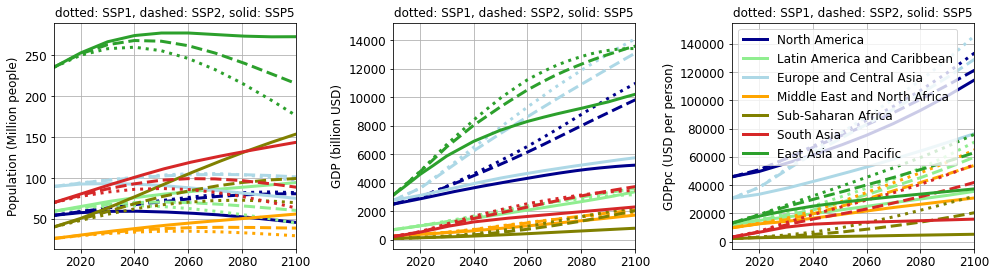

In [40]:
# region loop
colors = ['darkblue', 'lightgreen', 'lightblue', 'orange', 'olive', 'tab:red', 'tab:green']

# data/plot loop
data = [regional_pop[:,:,:]*1e-6, regional_gdp[:,:,:]*1e-9, regional_ypcc[:,:,:]]
ylabels=['Population (Million people)', 'GDP (billion USD)', 'GDPpc (USD per person)']
font=12
plt.figure(figsize=(14,4), facecolor='white')
plt.rcParams.update({'font.size': font})
plt.rc('xtick', labelsize=font)
plt.rc('ytick', labelsize=font)

for idat, dat in enumerate(data):
    plt.subplot(131+idat)
    ax=plt.gca()
    title='dotted: SSP1, dashed: SSP2, solid: SSP5'
    #else: title=''
    ax.set_title(title, fontsize=font)
    ax.set_xlim(2010,2100)
    ax.set_ylabel(ylabels[idat], fontsize=font)
    for ireg, region in enumerate(region_names):
        ax.plot(time, dat[ireg,:,0], label='', color=colors[ireg], linewidth=3, linestyle=':')
        ax.plot(time, dat[ireg,:,1], label='', color=colors[ireg], linewidth=3, linestyle='--')
        ax.plot(time, dat[ireg,:,2], label=region, color=colors[ireg], linewidth=3, linestyle='-')
    if idat == 2: ax.legend(loc='upper left')
    ax.grid(which='major')



plt.tight_layout()
plt.show()

## Damage function analysis - Regional aggregation

In [41]:
ref_SLR = regional_slr[:,:,-1]

inundated_regional_area = np.zeros_like(ref_SLR)
inundated_regional_people = np.zeros_like(ref_SLR)
inundated_regional_assets = np.zeros_like(ref_SLR)
exposure_regional_area  = np.zeros_like(ref_SLR)

inundated_regional_area2 = np.zeros_like(ref_SLR)
inundated_regional_people2 = np.zeros_like(ref_SLR)
inundated_regional_assets2 = np.zeros_like(ref_SLR)
exposure_regional_area2 = np.zeros_like(ref_SLR)


for ireg, region in enumerate(region_names):
    print('Calculating '+region)
    for islr in range(len(ref_SLR[0])):
        lsl = local_SLRs[islr,:,-1]
        
        inundated_regional_area[ireg,islr]      = np.sum(np.where(regional_mask==ireg, np.where(seg_mask, np.where(lsl>SDIKE, calcInundatedArea(areaparams, lsl), 0.0), 0.0), 0.0))
        inundated_regional_people[ireg,islr]    = np.sum(np.where(regional_mask==ireg, np.where(seg_mask, np.where(lsl>SDIKE, np.minimum(pop, calcInundatedArea(areaparams, lsl)*popdens_CIAM), 0.0), 0.0), 0.0)) / regional_pop[ireg,0,0]
        inundated_regional_assets[ireg,islr]    = np.sum(np.where(regional_mask==ireg, np.where(seg_mask, np.where(lsl>SDIKE, np.minimum(pop, calcInundatedArea(areaparams, lsl)*popdens_CIAM)*seg_ypcc[0,:,0], 0.0), 0.0), 0.0)) / regional_gdp[ireg,0,0]
        exposure_regional_area[ireg,islr]       = np.sum(np.where(regional_mask==ireg, np.where(seg_mask, np.where(lsl>SDIKE, calc_pSIGMA(pSIGMAparams, np.maximum(lsl, 0), SDIKE-np.minimum(lsl,0)), 0.0), 0.0), 0.0))
        
        inundated_regional_area2[ireg,islr]     = np.sum(np.where(regional_mask==ireg, np.where(seg_mask, calcInundatedArea(areaparams, lsl), 0.0), 0.0))
        inundated_regional_people2[ireg,islr]   = np.sum(np.where(regional_mask==ireg, np.where(seg_mask, np.minimum(pop, calcInundatedArea(areaparams, lsl)*popdens_CIAM), 0.0), 0.0)) / regional_pop[ireg,0,0]
        inundated_regional_assets2[ireg,islr]   = np.sum(np.where(regional_mask==ireg, np.where(seg_mask, np.minimum(pop, calcInundatedArea(areaparams, lsl)*popdens_CIAM)*seg_ypcc[0,:,0], 0.0), 0.0)) / regional_gdp[ireg,0,0]
        exposure_regional_area2[ireg,islr]      = np.sum(np.where(regional_mask==ireg, np.where(seg_mask, calc_pSIGMA(pSIGMAparams, np.maximum(lsl, 0), -np.minimum(lsl,0)), 0.0), 0.0))
        
        
area_fit_params = np.zeros((nreg,3))
asset_fit_params = np.zeros((nreg,3))
people_fit_params = np.zeros((nreg,3))

area_fit_stdev = np.zeros((nreg,3))
asset_fit_stdev = np.zeros((nreg,3))
people_fit_stdev = np.zeros((nreg,3))

area_fit_params2 = np.zeros((nreg,2))
asset_fit_params2 = np.zeros((nreg,2))
people_fit_params2 = np.zeros((nreg,2))

area_fit_stdev2 = np.zeros((nreg,2))
asset_fit_stdev2 = np.zeros((nreg,2))
people_fit_stdev2 = np.zeros((nreg,2))

for ireg in range(nreg):
    area_p, cov = curve_fit(logistic_function, ref_SLR[ireg], inundated_regional_area[ireg], p0=[1.0, 10.0, 3.0e6])
    area_fit_stdev[ireg,:] = np.sqrt(np.diag(cov))
    asset_p, cov = curve_fit(logistic_function, ref_SLR[ireg], inundated_regional_assets[ireg], p0=[1.0, 1.0, 10.0])
    asset_fit_stdev[ireg,:] = np.sqrt(np.diag(cov))
    people_p, cov = curve_fit(logistic_function, ref_SLR[ireg], inundated_regional_people[ireg], p0=[1.0, 1.0, 5.0])
    people_fit_stdev[ireg,:] = np.sqrt(np.diag(cov))
    
    area_fit_params[ireg,:] = area_p[:]
    asset_fit_params[ireg,:] = asset_p[:]
    people_fit_params[ireg,:] = people_p[:]
    
    area_p, cov = curve_fit(log_function, ref_SLR[ireg], inundated_regional_area2[ireg], p0=[1.0, 2.0])
    area_fit_stdev2[ireg,:] = np.sqrt(np.diag(cov))
    asset_p, cov = curve_fit(log_function, ref_SLR[ireg], inundated_regional_assets2[ireg], p0=[1.0, 2.0])
    asset_fit_stdev2[ireg,:] = np.sqrt(np.diag(cov))
    people_p, cov = curve_fit(log_function, ref_SLR[ireg], inundated_regional_people2[ireg], p0=[1.0, 2.0])
    people_fit_stdev2[ireg,:] = np.sqrt(np.diag(cov))
    
    area_fit_params2[ireg,:] = area_p[:]
    asset_fit_params2[ireg,:] = asset_p[:]
    people_fit_params2[ireg,:] = people_p[:]

    
    #### Fill in the fit parameters for inundation
    fit_params_with_initial_dikes[ireg,:3,:3] = np.asarray([area_fit_params[ireg], asset_fit_params[ireg], people_fit_params[ireg]])
    fit_params_without_initial_dikes[ireg,:3,:2] = np.asarray([area_fit_params2[ireg], asset_fit_params2[ireg], people_fit_params2[ireg]])
    
    fit_params_with_initial_dikes[ireg,:3,4:7] = np.asarray([area_fit_stdev[ireg], asset_fit_stdev[ireg], people_fit_stdev[ireg]])
    fit_params_without_initial_dikes[ireg,:3,3:5] = np.asarray([area_fit_stdev2[ireg], asset_fit_stdev2[ireg], people_fit_stdev2[ireg]])
    

Calculating North America
Calculating Latin America and Caribbean
Calculating Europe and Central Asia
Calculating Middle East and North Africa
Calculating Sub-Saharan Africa
Calculating South Asia
Calculating East Asia and Pacific


/tmp/ipykernel_10767/2220734320.py:8: RuntimeWarning: invalid value encountered in log
  return a*np.log(x*b+1)
/tmp/ipykernel_10767/2220734320.py:2: RuntimeWarning: overflow encountered in exp
  return A / (1.0 + np.exp(-k*(x-x0)))


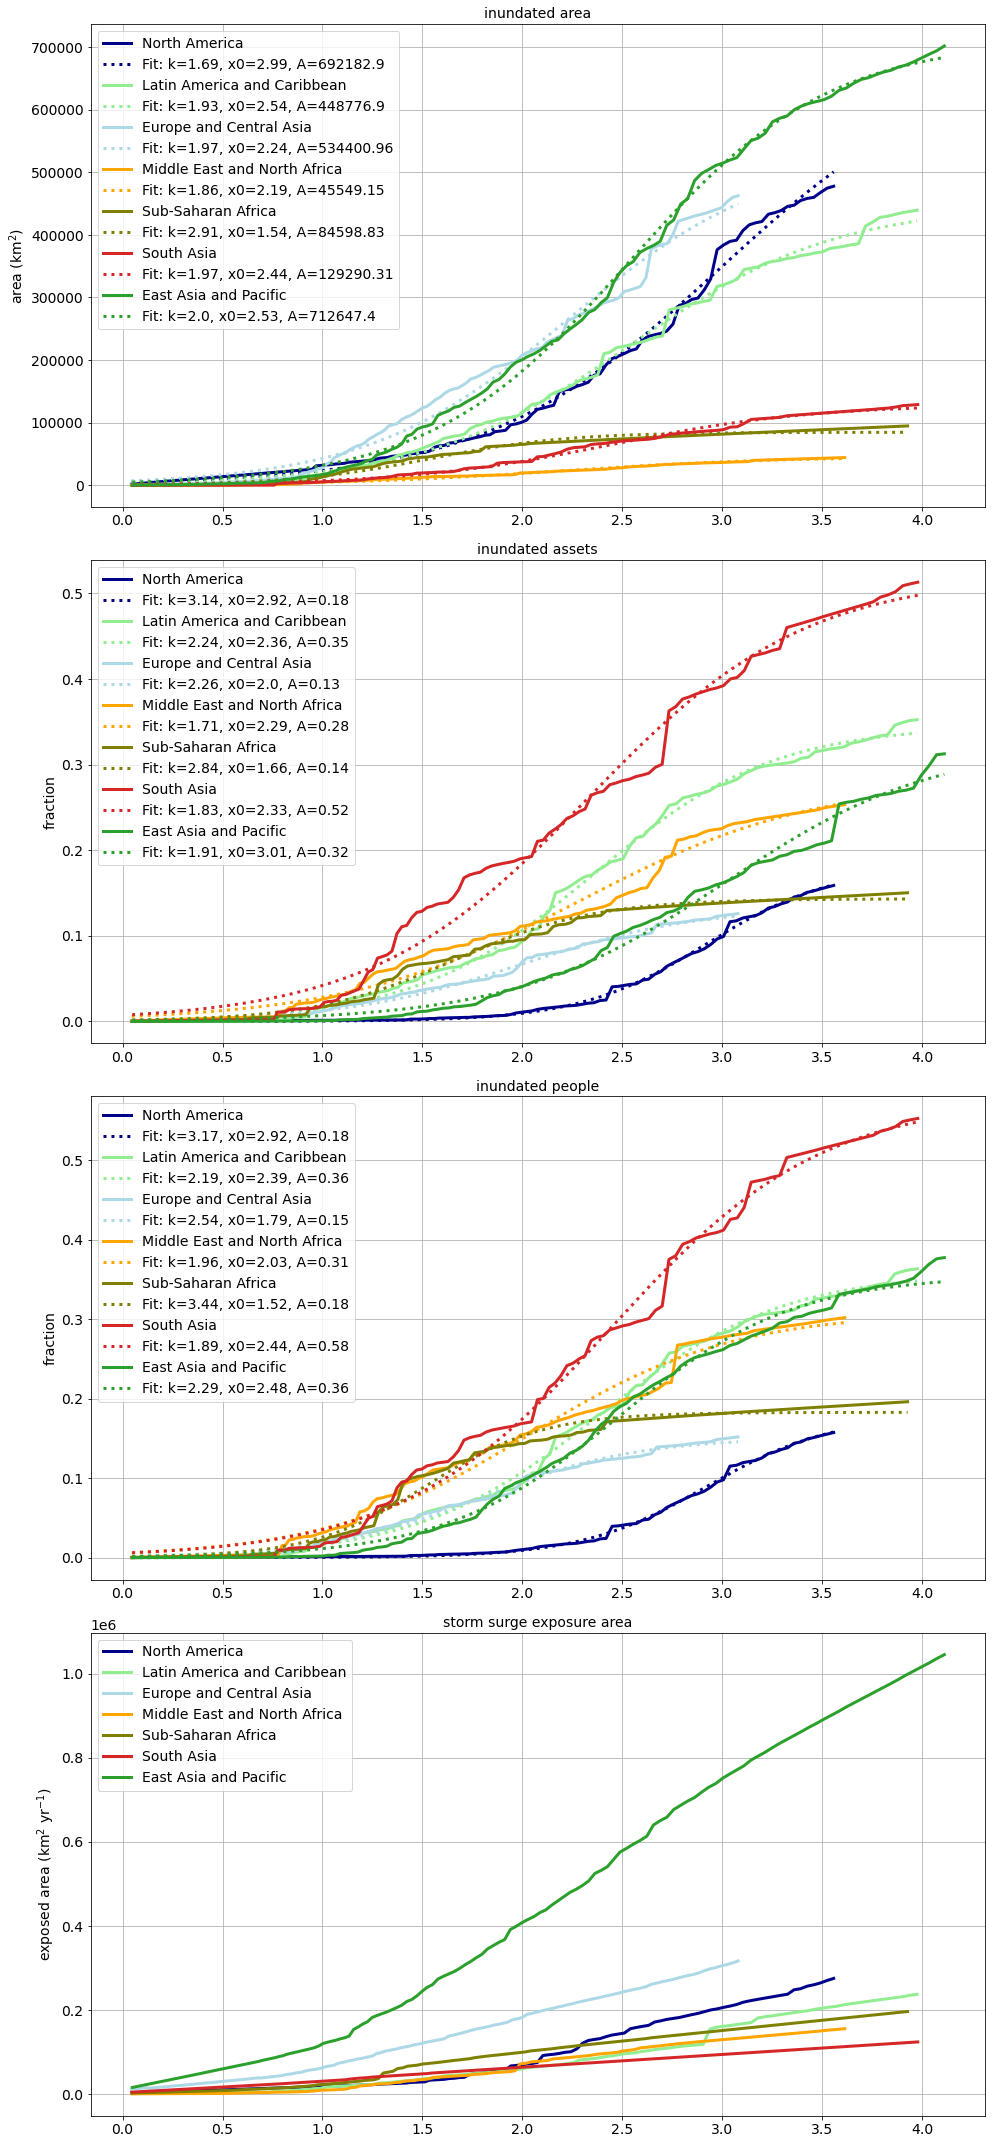

In [42]:
# data/plot loop
data = [inundated_regional_area, inundated_regional_assets, inundated_regional_people, exposure_regional_area]
fit_params = [area_fit_params, asset_fit_params, people_fit_params]

data2 = [inundated_regional_area2, inundated_regional_assets2, inundated_regional_people2, exposure_regional_area2]
fit_params2 = [area_fit_params2, asset_fit_params2, people_fit_params2]

ylabels=['area (km$^2$)', 'fraction', 'fraction', 'exposed area (km$^2$ yr$^{-1}$)']
titles=['inundated area', 'inundated assets', 'inundated people', 'storm surge exposure area']


colors=['darkblue', 'lightgreen', 'lightblue', 'orange', 'olive', 'tab:red', 'tab:green']
labels=region_names


font=14
plt.figure(figsize=(14,30), facecolor='white')
plt.rcParams.update({'font.size': font})
plt.rc('xtick', labelsize=font)
plt.rc('ytick', labelsize=font)

for idat, dat in enumerate(data):
    plt.subplot(411+idat)
    ax=plt.gca()
    ax.set_title(titles[idat], fontsize=font)
    #ax.set_xlim(0,3)
    ax.set_ylabel(ylabels[idat], fontsize=font)
    for ireg, region in enumerate(region_names):
        ax.plot(ref_SLR[ireg], dat[ireg], linewidth=3, label=labels[ireg], color=colors[ireg])
        #ax.plot(ref_SLR[ireg], data2[idat][ireg], linewidth=3, label=labels[ireg]+' w/o initial fp', color=colors[ireg], alpha=0.4)
        
        if idat < 3:
            ax.plot(ref_SLR[ireg], logistic_function2(ref_SLR[ireg], k=fit_params[idat][ireg,0], x0=fit_params[idat][ireg,1], A=fit_params[idat][ireg,2]), linewidth=3, linestyle=':',
                    label='Fit: k='+str(np.round(fit_params[idat][ireg,0],2))+', x0='+str(np.round(fit_params[idat][ireg,1],2))+', A='+str(np.round(fit_params[idat][ireg,2],2)), 
                    color=colors[ireg])
            #print(logistic_function2(0.0, k=fit_params[idat][ireg,0], x0=fit_params[idat][ireg,1], A=fit_params[idat][ireg,2]))

            
            #ax.plot(ref_SLR[ireg], log_function(ref_SLR[ireg], a=fit_params2[idat][ireg,0], b=fit_params2[idat][ireg,1]), linewidth=3, linestyle=':',
            #        label='Fit: a='+str(np.round(fit_params2[idat][ireg,0],2))+', b='+str(np.round(fit_params2[idat][ireg,1],2)),
            #        color=colors[ireg], alpha=0.4)

        #if idat == 3:
        #    ax.plot(ref_SLR[ireg], susceptible_area[ireg], linewidth=3, label='', color=colors[ireg], linestyle=':')

    ax.grid(which='major')
    ax.legend()

plt.tight_layout()
plt.show()

## Susceptibility and annual exposure

In [43]:
#### Do some bootstrapping to create relationship between asset susceptibility and SLR
n_new = 101
ref_SLR_regional = np.append(np.ones((nreg,n_new))*np.linspace(-1,0.0,n_new)[np.newaxis,:], regional_slr[:,:,-1], axis=1)
idx0 = n_new
nslr = len(ref_SLR_regional[0])
                    

asset_regional_fraction = np.zeros((nreg,nslr))
people_regional_fraction = np.zeros((nreg,nslr))

asset_regional_fraction2 = np.zeros((nreg,nslr))
people_regional_fraction2 = np.zeros((nreg,nslr))

asset_regional_likelihood = np.zeros((nreg,nslr))
people_regional_likelihood = np.zeros((nreg,nslr))

asset_regional_likelihood2 = np.zeros((nreg,nslr))
people_regional_likelihood2 = np.zeros((nreg,nslr))


              
for ireg, region in enumerate(region_names):
    print('Looking for segments in '+region)
    for islr in range(nslr):
        sl = ref_SLR_regional[ireg,islr]
        
        if sl <= 0: lsl = sl
        else: lsl = local_SLRs[islr-n_new,:,-1]
        
        asset_regional_fraction[ireg,islr] = np.sum(np.where(regional_mask==ireg,   np.where(seg_mask, np.where(surge1000 + lsl > SDIKE, np.minimum(pop, calcInundatedArea(areaparams, lsl+surge1000)*popdens_CIAM)*seg_ypcc[0,:,0], 0.0), 0.0), 0.0)) / regional_gdp[ireg,0,0]
        people_regional_fraction[ireg,islr] = np.sum(np.where(regional_mask==ireg,  np.where(seg_mask, np.where(surge1000 + lsl > SDIKE, np.minimum(pop, calcInundatedArea(areaparams, lsl+surge1000)*popdens_CIAM), 0.0), 0.0),0.0)) / regional_pop[ireg,0,0]

        asset_regional_fraction2[ireg,islr] = np.sum(np.where(regional_mask==ireg,   np.where(seg_mask, np.minimum(pop, calcInundatedArea(areaparams, lsl+surge1000)*popdens_CIAM)*seg_ypcc[0,:,0], 0.0), 0.0)) / regional_gdp[ireg,0,0]
        people_regional_fraction2[ireg,islr] = np.sum(np.where(regional_mask==ireg,  np.where(seg_mask, np.minimum(pop, calcInundatedArea(areaparams, lsl+surge1000)*popdens_CIAM), 0.0),0.0)) / regional_pop[ireg,0,0]

        asset_regional_likelihood[ireg,islr] = np.sum(np.where(regional_mask==ireg,   np.where(seg_mask,  np.where(surge1000 + lsl > SDIKE, np.minimum(pop, calc_pSIGMA(pSIGMAparams, np.maximum(lsl, 0), SDIKE-surge1-np.minimum(lsl,0))*popdens_CIAM)*seg_ypcc[0,:,0], 0.0), 0.0), 0.0)) / regional_gdp[ireg,0,0]
        people_regional_likelihood[ireg,islr] = np.sum(np.where(regional_mask==ireg,   np.where(seg_mask,  np.where(surge1000 + lsl > SDIKE, np.minimum(pop, calc_pSIGMA(pSIGMAparams, np.maximum(lsl, 0), SDIKE-surge1-np.minimum(lsl,0))*popdens_CIAM), 0.0), 0.0), 0.0)) / regional_pop[ireg,0,0]
    
        asset_regional_likelihood2[ireg,islr] = np.sum(np.where(regional_mask==ireg,   np.where(seg_mask,  np.minimum(pop, calc_pSIGMA(pSIGMAparams, np.maximum(lsl, 0), -np.minimum(lsl,0))*popdens_CIAM)*seg_ypcc[0,:,0], 0.0), 0.0)) / regional_gdp[ireg,0,0]
        people_regional_likelihood2[ireg,islr] = np.sum(np.where(regional_mask==ireg,   np.where(seg_mask,  np.minimum(pop, calc_pSIGMA(pSIGMAparams, np.maximum(lsl, 0),-np.minimum(lsl,0))*popdens_CIAM), 0.0), 0.0)) / regional_pop[ireg,0,0]



Looking for segments in North America
Looking for segments in Latin America and Caribbean
Looking for segments in Europe and Central Asia
Looking for segments in Middle East and North Africa
Looking for segments in Sub-Saharan Africa
Looking for segments in South Asia
Looking for segments in East Asia and Pacific


In [44]:
asset_fit_params = np.zeros((nreg,4))
people_fit_params = np.zeros((nreg,4))
asset_fit_stdev = np.zeros((nreg,4))
people_fit_stdev = np.zeros((nreg,4))

asset_fit_params2 = np.zeros((nreg,3))
people_fit_params2 = np.zeros((nreg,3))
asset_fit_stdev2 = np.zeros((nreg,3))
people_fit_stdev2 = np.zeros((nreg,3))

asset_likelihood_fit_params = np.zeros((nreg,4))
people_likelihood_fit_params = np.zeros((nreg,4))
asset_likelihood_fit_stdev = np.zeros((nreg,4))
people_likelihood_fit_stdev = np.zeros((nreg,4))

asset_likelihood_fit_params2 = np.zeros((nreg,3))
people_likelihood_fit_params2 = np.zeros((nreg,3))
asset_likelihood_fit_stdev2 = np.zeros((nreg,3))
people_likelihood_fit_stdev2 = np.zeros((nreg,3))

# Create some initial guesses to make sure that fit is good
p0s = np.zeros((nreg,4))
p0s_sus = np.zeros((nreg,3))

guess_p0s = np.asarray([1.5, 0.0, 0.20, 0])
guess_p0s_sus = np.asarray([0.2, 0.3, 0.3])

p0s[:,:] = guess_p0s[np.newaxis,:]
p0s_sus[:,:] = guess_p0s_sus[np.newaxis,:]

for ireg in range(nreg):
    print(region_names[ireg])
    # Generally suscpetible fractions
    asset_p, cov = curve_fit(logistic_function2, ref_SLR_regional[ireg, idx0:], asset_regional_fraction[ireg, idx0:], maxfev=10000)
    asset_fit_stdev[ireg,:] = np.sqrt(np.diag(cov))
    people_p, cov = curve_fit(logistic_function2, ref_SLR_regional[ireg, idx0:], people_regional_fraction[ireg, idx0:], maxfev=10000)
    people_fit_stdev[ireg,:] = np.sqrt(np.diag(cov))
    
    asset_fit_params[ireg,:] = asset_p[:]
    people_fit_params[ireg,:] = people_p[:]
    
    asset_p, cov = curve_fit(log_function2, ref_SLR_regional[ireg, idx0:], asset_regional_fraction2[ireg, idx0:], maxfev=10000, p0=p0s_sus[ireg])
    asset_fit_stdev2[ireg,:] = np.sqrt(np.diag(cov))
    people_p, cov = curve_fit(log_function2, ref_SLR_regional[ireg, idx0:], people_regional_fraction2[ireg, idx0:], maxfev=10000, p0=p0s_sus[ireg])
    people_fit_stdev2[ireg,:] = np.sqrt(np.diag(cov))

    asset_fit_params2[ireg,:] = asset_p[:]
    people_fit_params2[ireg,:] = people_p[:]
    
    
    # Exposure likelihoods
    asset_p, cov = curve_fit(logistic_function2, ref_SLR_regional[ireg, idx0:], asset_regional_likelihood[ireg, idx0:], maxfev=10000, p0=p0s[ireg])
    asset_likelihood_fit_stdev[ireg,:] = np.sqrt(np.diag(cov))
    people_p, cov = curve_fit(logistic_function2, ref_SLR_regional[ireg, idx0:], people_regional_likelihood[ireg, idx0:], maxfev=10000, p0=p0s[ireg])
    people_likelihood_fit_stdev[ireg,:] = np.sqrt(np.diag(cov))
    
    asset_likelihood_fit_params[ireg,:] = asset_p[:]
    people_likelihood_fit_params[ireg,:] = people_p[:]
    
    asset_p, cov = curve_fit(log_function2, ref_SLR_regional[ireg, idx0:], asset_regional_likelihood2[ireg, idx0:], maxfev=10000)
    asset_likelihood_fit_stdev2[ireg,:] = np.sqrt(np.diag(cov))
    people_p, cov = curve_fit(log_function2, ref_SLR_regional[ireg, idx0:], people_regional_likelihood2[ireg, idx0:], maxfev=10000)
    people_likelihood_fit_stdev2[ireg,:] = np.sqrt(np.diag(cov))
    
    asset_likelihood_fit_params2[ireg,:] = asset_p[:]
    people_likelihood_fit_params2[ireg,:] = people_p[:]
    
    #### Fill in the fit parameters for storm surge susceptibility and exposure
    fit_params_with_initial_dikes[ireg,3:,:4] = np.asarray([asset_fit_params[ireg], people_fit_params[ireg], asset_likelihood_fit_params[ireg], people_likelihood_fit_params[ireg]])
    fit_params_without_initial_dikes[ireg,3:,:3] = np.asarray([asset_fit_params2[ireg], people_fit_params2[ireg], asset_likelihood_fit_params2[ireg], people_likelihood_fit_params2[ireg]])

    fit_params_with_initial_dikes[ireg,3:,4:] = np.asarray([asset_fit_stdev[ireg], people_fit_stdev[ireg], asset_likelihood_fit_params[ireg], people_likelihood_fit_stdev[ireg]])
    fit_params_without_initial_dikes[ireg,3:,3:] = np.asarray([asset_fit_stdev2[ireg], people_fit_stdev2[ireg], asset_likelihood_fit_params2[ireg], people_likelihood_fit_stdev2[ireg]])


North America
Latin America and Caribbean
Europe and Central Asia
Middle East and North Africa
Sub-Saharan Africa
South Asia
East Asia and Pacific


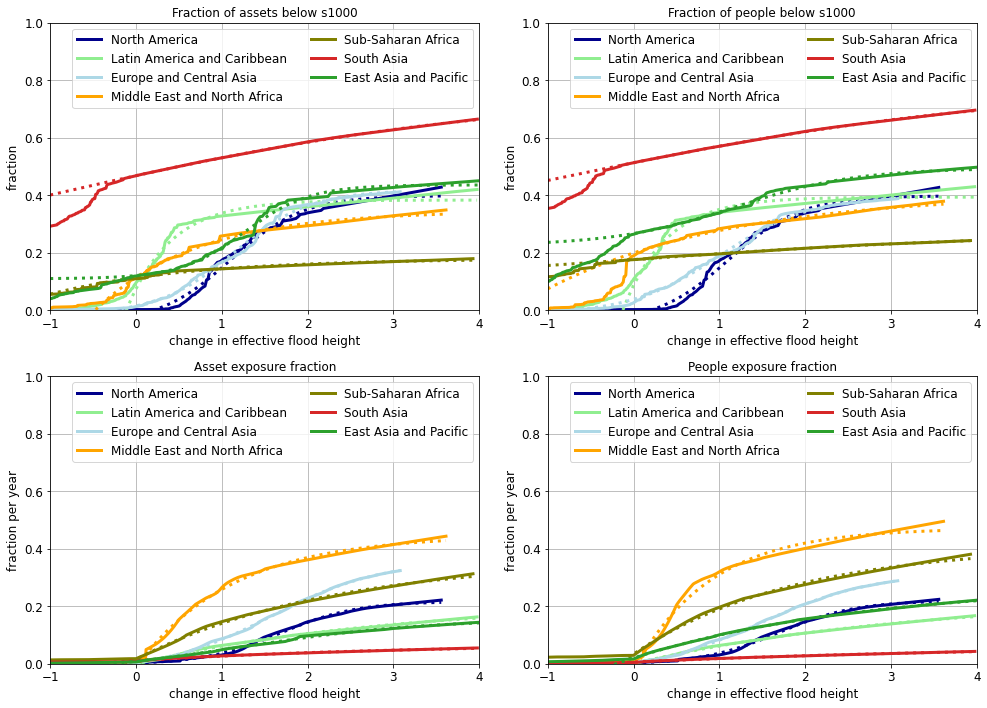

In [46]:
# data/plot loop
# data/plot loop
data = [asset_regional_fraction, people_regional_fraction, asset_regional_likelihood, people_regional_likelihood]
fit_params = [asset_fit_params, people_fit_params, asset_likelihood_fit_params, people_likelihood_fit_params]

data2 = [asset_regional_fraction2, people_regional_fraction2, asset_regional_likelihood2, people_regional_likelihood2]
fit_params2 = [asset_fit_params2, people_fit_params2, asset_likelihood_fit_params2, people_likelihood_fit_params2]


ylabels=['fraction', 'fraction', 'fraction per year', 'fraction per year']
titles=['Fraction of assets below s1000',
        'Fraction of people below s1000',
        'Asset exposure fraction',
        'People exposure fraction']


labels=region_names
colors_reg=colors

font=12
plt.figure(figsize=(14,10), facecolor='white')
plt.rcParams.update({'font.size': font})
plt.rc('xtick', labelsize=font)
plt.rc('ytick', labelsize=font)

for idat, dat in enumerate(data):
    plt.subplot(221+idat)
    ax=plt.gca()
    ax.set_title(titles[idat], fontsize=font)
    ax.set_xlim(-1,4)
    ax.set_xlabel('change in effective flood height')
    ax.set_ylim(0,1)
    #else:
    #    ax.set_ylim(0,5)
    ax.set_ylabel(ylabels[idat], fontsize=font)
    for ireg in range(nreg):
        
        ax.plot(ref_SLR_regional[ireg], data[idat][ireg], linewidth=3, label=labels[ireg], color=colors_reg[ireg])
        ax.plot(ref_SLR_regional[ireg], logistic_function2(ref_SLR_regional[ireg], k=fit_params[idat][ireg,0], x0=fit_params[idat][ireg,1], A=fit_params[idat][ireg,2], c=fit_params[idat][ireg,3]), linewidth=3,
                #label='Fit: k='+str(np.round(fit_params[idat][ireg,0],2))+', x0='+str(np.round(fit_params[idat][ireg,1],2))+', A='+str(np.round(fit_params[idat][ireg,2],2))+', c='+str(np.round(fit_params[idat][ireg,3],2)),
                label='',
                linestyle=':', color=colors_reg[ireg])
        
        
        #ax.plot(ref_SLR_regional[ireg], data2[idat][ireg], linewidth=3, label=labels[ireg]+' w/o initial fp', color=colors[ireg], alpha=0.4)
        #ax.plot(ref_SLR_regional[ireg, idx0:], log_function2(ref_SLR_regional[ireg, idx0:], a=fit_params2[idat][ireg,0], b=fit_params2[idat][ireg,1], c=fit_params2[idat][ireg,2]), linewidth=3,
        #            #label='Fit: a='+str(np.round(fit_params2[idat][ireg,0],2))+', b='+str(np.round(fit_params2[idat][ireg,1],2))+', c='+str(np.round(fit_params2[idat][ireg,2],2)),
        #            linestyle=':', color=colors[ireg])    

        
    ax.grid(which='major')
    ax.legend(ncol=2, fontsize=font)


plt.tight_layout()
plt.show()

## Write the fit parameters into files

In [47]:
fit_functions = ['inund_params_area', 'inund_params_assets', 'inund_params_people', 
                 'storm_suscept_params_assets', 'storm_suscept_params_people', 
                 'storm_exposure_params_assets', 'storm_exposure_params_people']

outpath = inputFRISIA+'fit_function_parameters/'

for ifit, fit_function in enumerate(fit_functions):
    # Make files for each fit function with global aggregation and initial flood protection  
    
    ########### Regional aggregation
    regions = region_names
    
    data = {
        'Region': regions
    }

    data['k']  = fit_params_with_initial_dikes[:,ifit,0]
    data['x0'] = fit_params_with_initial_dikes[:,ifit,1]
    data['A']  = fit_params_with_initial_dikes[:,ifit,2]
    data['c']  = fit_params_with_initial_dikes[:,ifit,3]

    data['k SD']  = fit_params_with_initial_dikes[:,ifit,4]
    data['x0 SD'] = fit_params_with_initial_dikes[:,ifit,5]
    data['A SD']  = fit_params_with_initial_dikes[:,ifit,6]
    data['c SD']  = fit_params_with_initial_dikes[:,ifit,7]
    
    df = pd.DataFrame(data)
    df.to_csv(outpath+AggregationName+'_'+fit_function+'.csv', index=False)
    data = {
        'Region': regions
    }

    data['a'] = fit_params_without_initial_dikes[:,ifit,0]
    data['b'] = fit_params_without_initial_dikes[:,ifit,1]
    data['c'] = fit_params_without_initial_dikes[:,ifit,2]
    
    data['a SD'] = fit_params_without_initial_dikes[:,ifit,3]
    data['b SD'] = fit_params_without_initial_dikes[:,ifit,4]
    data['c SD'] = fit_params_without_initial_dikes[:,ifit,5]
    
    df = pd.DataFrame(data)
    
    df.to_csv(outpath+AggregationName+'_'+fit_function+'_no_initial_dikes.csv', index=False)

    
        

## SLR analysis (regional and/or wheighted vs calculated global)

In [48]:
from scipy.optimize import curve_fit

def linear_fit(x,a):
    return a*x

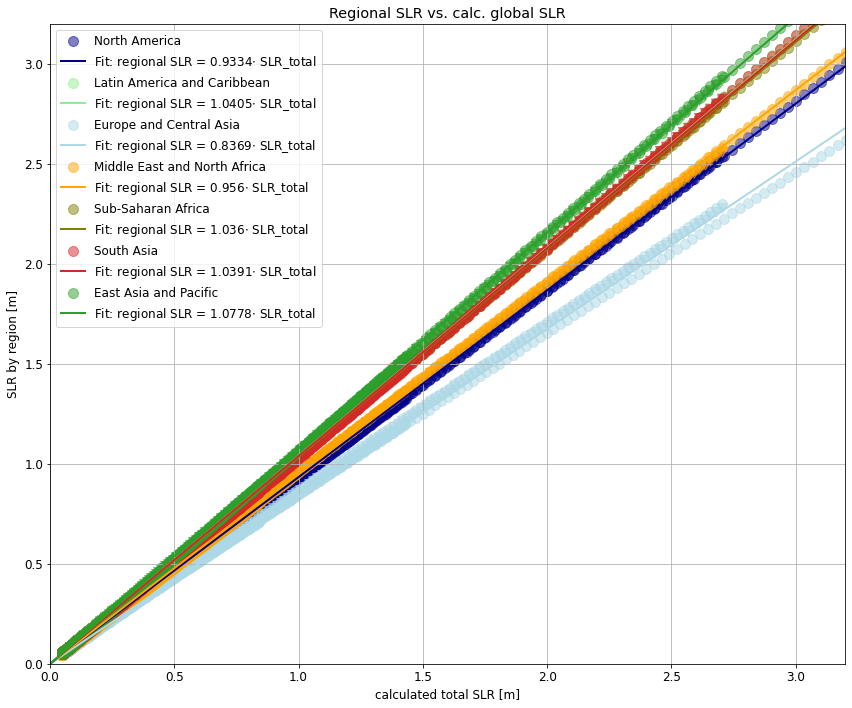

In [49]:
x = np.linspace(0, 3.2,100)
SLR_factors=np.zeros((nreg))

for i in range(nreg):
    SLR_factors[i], dum = curve_fit(linear_fit, SLR_total[:,:].flatten(), regional_slr[i].flatten())

def calcSLR(SLRs, weights):
    return np.sum(np.asarray(SLRs)[:,np.newaxis,:]*np.asarray(weights)[:,:,np.newaxis], axis=0)

SLRs = [SLR_thermo[:,2], SLR_LWS[:,2], SLR_MG[:,2], SLR_GIS[:,2], SLR_AIS[:,2]]
weights = [np.ones(nreg), np.ones(nreg), regional_wt_MG, regional_wt_GIS, regional_wt_AIS]
calc_regional_slr = calcSLR(SLRs, weights)


font=12
plt.figure(figsize=(12,10), facecolor='white')
plt.rcParams.update({'font.size': font})
plt.rc('xtick', labelsize=font)
plt.rc('ytick', labelsize=font)

ax=plt.gca()
ax.set_ylabel('SLR by region [m]')
ax.set_xlabel('calculated total SLR [m]')
ax.set_xlim(0,3.2)
ax.set_ylim(0,3.2)
ax.set_title('Regional SLR vs. calc. global SLR')

for i, region in enumerate(region_names):
    ax.scatter(SLR_total[:,:].flatten(), regional_slr[i].flatten(), color=colors[i], alpha=0.5, label=region, s=100)
    ax.scatter(SLR_total[:,2], calc_regional_slr[i], color=colors[i], alpha=0.5, label='', marker='v', s=100)
    
    ax.plot(x, linear_fit(x,SLR_factors[i]), color=colors[i], lw=2, label='Fit: regional SLR = '+str(np.round(SLR_factors[i],4))+'$\cdot$ SLR_total')

ax.grid()   
ax.legend()

#ax.set_xlim(0.7,1.0)
#ax.set_ylim(0.5,1.2)

plt.tight_layout()
plt.show()

## Also write the DIVA information into files

In [50]:
variables = ['SLR_factor', 'SLR_weight_MG', 'SLR_weight_GIS', 'SLR_weight_AIS', 'average_fp_height', 'total_fp_length', 'population_fraction', 'asset_fraction']

outpath = inputFRISIA+'aggregated_data/'



########### Regional aggregation

data = {
    'Region': region_names
}

values = [SLR_factors, regional_wt_MG, regional_wt_GIS, regional_wt_AIS,
          dike_height_by_region[:], coast_length_by_region[:], 
          regional_pop[:,0,0]/global_pop[0,0], regional_gdp[:,0,0]/global_gdp[0,0]]

for ivar, variable in enumerate(variables): data[variable] = values[ivar]

df = pd.DataFrame(data)
df.to_csv(outpath+AggregationName+'_information.csv', index=False)



## Population and GDP analysis
##### Here, just prepare the required data in a new csv file

In [51]:

data = {
    'Time': np.linspace(2010,2200,191)
}

for isc, scenario in enumerate(scenarios):
    
    data['Coastal GDP (global) '+scenario] = global_gdp[:,isc]*1.0e-9
    for ireg, region in enumerate(region_names) : data['Coastal GDP ('+region+'th pctl) '+scenario] = regional_gdp[ireg,:,isc]*1.0e-9
        
    data['Coastal pop (global) '+scenario] = global_pop[:,isc]*1.0e-6
    for ireg, region in enumerate(region_names) : data['Coastal pop ('+region+'th pctl) '+scenario] = regional_pop[ireg,:,isc]*1.0e-6


df = pd.DataFrame(data)
df.to_csv(inputFRISIA+'coastal_GDP_and_population_'+AggregationName+'.csv', index=False)

df.head()

,Time,Coastal GDP (global) ssp126,Coastal GDP (North Americath pctl) ssp126,Coastal GDP (Latin America and Caribbeanth pctl) ssp126,Coastal GDP (Europe and Central Asiath pctl) ssp126,Coastal GDP (Middle East and North Africath pctl) ssp126,Coastal GDP (Sub-Saharan Africath pctl) ssp126,Coastal GDP (South Asiath pctl) ssp126,Coastal GDP (East Asia and Pacificth pctl) ssp126,Coastal pop (global) ssp126,...,Coastal GDP (South Asiath pctl) ssp585,Coastal GDP (East Asia and Pacificth pctl) ssp585,Coastal pop (global) ssp585,Coastal pop (North Americath pctl) ssp585,Coastal pop (Latin America and Caribbeanth pctl) ssp585,Coastal pop (Europe and Central Asiath pctl) ssp585,Coastal pop (Middle East and North Africath pctl) ssp585,Coastal pop (Sub-Saharan Africath pctl) ssp585,Coastal pop (South Asiath pctl) ssp585,Coastal pop (East Asia and Pacificth pctl) ssp585
0,2010.0,9693.231394,2504.847864,707.696134,2765.295160,258.925409,92.217589,233.503008,3130.746230,575.610658,...,233.503008,3130.746230,575.610658,54.451630,59.451961,89.720312,26.097613,40.232562,70.096039,235.560540
1,2011.0,10059.146764,2552.315604,734.939188,2847.757527,270.776232,98.313217,264.788088,3290.256908,580.323016,...,265.250958,3295.454037,580.547434,55.039297,59.822817,90.279795,26.459827,41.029507,70.838342,237.077849
2,2012.0,10429.038757,2600.229234,762.488293,2930.884960,282.862401,104.582233,296.704369,3451.287268,585.035374,...,297.636750,3461.786661,585.484209,55.626963,60.193672,90.839278,26.822040,41.826452,71.580645,238.595157
3,2013.0,10802.907374,2648.588753,790.343450,3014.677458,295.183915,111.024637,329.251850,3613.837310,589.747732,...,330.660382,3629.744102,590.420984,56.214630,60.564528,91.398761,27.184254,42.623397,72.322948,240.112466
4,2014.0,11180.752615,2697.394163,818.504659,3099.135021,307.740776,117.640430,362.430532,3777.907035,594.460090,...,364.321856,3799.326359,595.357760,56.802297,60.935384,91.958244,27.546467,43.420342,73.065252,241.629774
